## Sentiment Analysis

dataset link: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis?resource=download

(also in this folder)

In [1]:
# imports 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import re
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sayyedjilani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## EDA

In [46]:
# view dataset and labels
movies_df = pd.read_csv('./../../../movie.csv')
movies_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [47]:
# view distribution of labels
movies_df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

In [48]:
# view example text
movies_df['text'][0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

The text iteslf needs to be processed, which includes removing stop words and break each word down to its indivdual stem

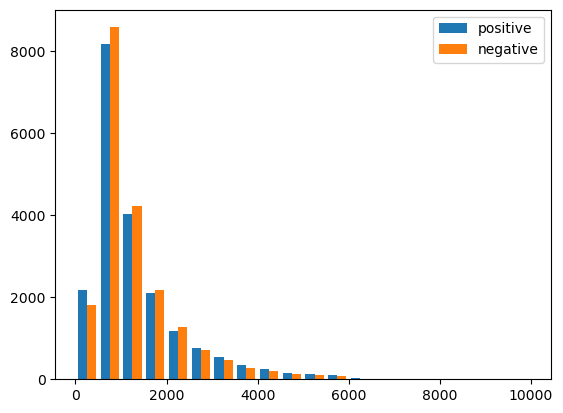

Longest positive review: 13704
Longest negative review: 8969

Longest positive review: 1328.0832791151595
Longest negative review: 1292.5369898596334


In [49]:
X = movies_df.drop('label', axis=1).values
y = movies_df['label'].values

# a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(np.squeeze(X)) if y[i]]

# a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(np.squeeze(X)) if not y[i]]


plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 10000), label=['positive', 'negative'])

plt.legend()
plt.show()

# check the longest reviews
print('Longest positive review:', max(text_lengths_pos))
print('Longest negative review:', max(text_lengths_neg))
# check avg review length
print('\nLongest positive review:', np.mean(text_lengths_pos))
print('Longest negative review:', np.mean(text_lengths_neg))

On average the lengths of the reviews are quite similar. Similarly, the distribution of word lengths is also quite similar across the two classes, and the very large lengths can be considered to be outliers. Given the similar distributions, applying a word count limit as part of our processing may not be neccessary.

In [50]:
# split dataset 
X = movies_df.drop('label', axis=1).values
y = movies_df['label'].values

# split the data into training and temporary set (80% training + 20% temp set)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# split the temp set into testing and validation sets (80% training, 10% validation and 10% test set of the original dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [51]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)

print('split sizes\n')
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)
print('y_test: ', y_test.shape)

split sizes

X_train:  (32000,)
X_val:  (4000,)
X_test:  (4000,)
y_train:  (32000,)
y_val:  (4000,)
y_test:  (4000,)


Do positive film reviews tend to have greater length, or is it the other way around? We can utilze histograms to see the distibution of review length by sentiment.

In [52]:
def process_text(text):
    '''
    Input:
        text: a string containing a film review
    Output:
        clean_text: a list of words containing the processed text
    '''

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # tokenize text by only using concurrent letters
    words = re.findall(r'[a-z]+', text.lower())

    clean_text = []
    for word in words:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            clean_text.append(stem_word)

    return clean_text

It should be noted, the processing would take careful consideration of the application. Given our goal is to infer sentiment, punctuation may not be required as sentence structure may not play a part in inferring sentiment.

In [53]:
print('The following is an example text:')
print(X_train[0])
print('\nThefollowing is an example of processed text:')
print(process_text(X_train[0]))

The following is an example text:
I watched it last night and again this morning - that's how much I liked it. There is something about this movie... When the movie was almost over, I was about to cry. I would strongly recommend "Latter Days" to my friends - it's definitely worth seeing! I agree with those who say that some parts of the movie do not look very realistic. For example, both main characters are totally cute and in perfect physical shape (although, round is also a type of shape:) ). I rarely meet people like this as singles and I have never met any in couples. Other parts of the movie, including all those "coincidences", do not look very realistic as well. BUT, after all it is A MOVIE, not a life story.

Thefollowing is an example of processed text:
['watch', 'last', 'night', 'morn', 'much', 'like', 'someth', 'movi', 'movi', 'almost', 'cri', 'would', 'strongli', 'recommend', 'latter', 'day', 'friend', 'definit', 'worth', 'see', 'agre', 'say', 'part', 'movi', 'look', 'realis

In [54]:
# with extremely large datasets (GB to TB), the counts should not be stored in a dictionary. Splitting the data and utilzing the MapReduce paradigm
# over various nodes may become necessary 

def count_text(mapper, X, y):
    '''
    Input:
        mapper: dcitionary used to store tuples of word and sentiment counts
        X: an array of texts
        y: an array of corresponding sentiment of each text 
    Output:
        result: a dictionary mapping each pair to its frequency { (word, sentiment) : count }
    '''
    
    for y, text in zip(y, X):
        for word in process_text(text):

            # word, sentiment tuple as kay
            key = (word, y)
            
            # if the key exists in the dictionary, increment the count
            if mapper.get(key,0) != 0:
                mapper[key] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                mapper[key] = 1

    return mapper

In [55]:
# testing functionality of count_text
count_text({}, X_train[0:2], y_train[0:2])

{('watch', 1): 1,
 ('last', 1): 1,
 ('night', 1): 1,
 ('morn', 1): 1,
 ('much', 1): 1,
 ('like', 1): 3,
 ('someth', 1): 4,
 ('movi', 1): 5,
 ('almost', 1): 1,
 ('cri', 1): 1,
 ('would', 1): 1,
 ('strongli', 1): 1,
 ('recommend', 1): 1,
 ('latter', 1): 1,
 ('day', 1): 1,
 ('friend', 1): 1,
 ('definit', 1): 1,
 ('worth', 1): 1,
 ('see', 1): 1,
 ('agre', 1): 1,
 ('say', 1): 2,
 ('part', 1): 2,
 ('look', 1): 2,
 ('realist', 1): 2,
 ('exampl', 1): 1,
 ('main', 1): 1,
 ('charact', 1): 2,
 ('total', 1): 1,
 ('cute', 1): 1,
 ('perfect', 1): 1,
 ('physic', 1): 1,
 ('shape', 1): 2,
 ('although', 1): 2,
 ('round', 1): 1,
 ('also', 1): 1,
 ('type', 1): 1,
 ('rare', 1): 1,
 ('meet', 1): 1,
 ('peopl', 1): 1,
 ('singl', 1): 1,
 ('never', 1): 1,
 ('met', 1): 1,
 ('coupl', 1): 1,
 ('includ', 1): 1,
 ('coincid', 1): 1,
 ('well', 1): 1,
 ('life', 1): 1,
 ('stori', 1): 2,
 ('western', 1): 2,
 ('one', 1): 2,
 ('favourit', 1): 1,
 ('john', 1): 2,
 ('ford', 1): 3,
 ('lack', 1): 1,
 ('certain', 1): 1,
 ('film

In [56]:
# store training frequencies 
train_freq = count_text({}, X_train, y_train)

## Models

#### Approach 1: Logistic Regression 

To train this, we will be hand-coding the logistic regression (instead of letting other packages do the work for us). The goal here will be to iteate until we find the correct weights that will minimize the cost function. We will be utilizing the following functions:


##### Sigmoid function
$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

As the next step, we will be using the cost function used specifically for logistic regression. This is the average of the log loss across all training examples:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.
* $\theta$ represents the weights associated with the features.

Each indidual training data will have a bias term, positive term and negative term associated with the word

#### Gradient Descent
We will then proceed to using gradient descent for the purposes of our training. 

* training will be done for a set number of iterations
* for each iteration, we will calulate the cost from the cost function by utilizing all of the training data 
* we will then update the learned weights associated with our function using a set `alpha`


In [97]:
# supporting functions for training 

def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    h = 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    return h


def gradientDescent(x, y, theta, alpha, num_iters, decay_factor=0.9):
    '''
    Input:
        x: matrix of features which is of dimension (m,3), where m is the number of training samples
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: initialized weight vector of dimension (3,1) with zeros
        alpha: learning rate (initialized at 0.05)
        num_iters: number of iterations to train the model for
        decay_factor: apply a decay to alpha after each iteration to start at large alpha, and get slower with iterations
    Output:
        J: the final cost
        theta: the final weight vector
    '''

    m = x.shape[0]
    
    for i in range(0, num_iters):

        # get z, the dot product of x and theta
        z = x @ theta
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1/m * np.sum(y.T @ np.log(h+1e-20) + (1-y).T @ np.log(1-h+1e-20))

        # update the weights theta
        theta = theta - alpha/m * np.sum(x.T @ (h-y), axis=1, keepdims=True)


        if i % 50 == 0:
            print(f"running iteration {i}")
            print(f"current loss {J}")
            print(f"current alpha {alpha:.12f}")
            print()

        # apply decay factor after each iteration
        alpha *= decay_factor

    return J, theta




def extract_features(text, freqs, process_text=process_text):
    '''
    Input: 
        text: string containing a film review
        freqs: a dictionary corresponding to the count of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_text tokenizes, stems, and removes stopwords
    word_list = process_text(text)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    
    # loop through each word in the list of words
    for word in word_list:
        
        # increment the word count for the positive label 1
        x[1] += freqs.get((word, 1), 0)
        
        # increment the word count for the negative label 0
        x[2] += freqs.get((word, 0), 0)
        
    
    x = x[None, :]  
    assert(x.shape == (1, 3))
    return x


In [93]:
# Train the model to retrieve final weights
X = np.zeros((len(X_train), 3))

for i in range(len(X_train)):
    X[i, :]= extract_features(X_train[i], train_freq)

Y = y_train.astype(float)

In [98]:
# initializing theta with zeroes, alpha at 0.5, running for 1000 epochs
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 0.5, 500) 
print(f"The cost after training is {J}.")
print(f"The resulting vector of weights is {theta}")

running iteration 0
current loss 0.6931471805600389
current alpha 0.500000000000

running iteration 50
current loss 22.949577798733902
current alpha 0.002576887604

running iteration 100
current loss 23.102124061144693
current alpha 0.000013280699

running iteration 150
current loss 22.949577798733902
current alpha 0.000000068446

running iteration 200
current loss 22.949577798733902
current alpha 0.000000000353

running iteration 250
current loss 22.949577798733902
current alpha 0.000000000002

running iteration 300
current loss 21.00945452995878
current alpha 0.000000000000

running iteration 350
current loss 0.6954113652107456
current alpha 0.000000000000

running iteration 400
current loss 0.6954054348749223
current alpha 0.000000000000

running iteration 450
current loss 0.6954054043533008
current alpha 0.000000000000

The cost after training is 0.6954054041960899.
The resulting vector of weights is [[-4.62379890e-11]
 [-3.10528070e-07]
 [ 2.89652789e-07]]


In [99]:
def predict_logistic_review(film_review, freqs, theta):
    '''
    Input: 
        film_review: a film review
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights trained
    Output: 
        y_pred: the probability of a review being positive or negative
    '''
    
    # extract the features of the film review 
    x = extract_features(film_review, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(x @ theta)
    
    return y_pred

In [101]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_review=predict_logistic_review):
    """
    Input: 
        test_x: a list of reviews
        test_y: (m, 1) vector with the corresponding labels for the list of reviews
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of reviews classified correctly) / (total # of reviews)
    """
        
    # the list for storing predictions
    y_hat = []
    
    for review in test_x:
        # get the label prediction for the tweet
        y_pred = predict_review(review, freqs, theta)

        # using 0.7 as our threshold 
        if y_pred > 0.7:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    y_hat = np.array(y_hat)
    test_y = np.ravel(test_y)
    
    accuracy = np.sum(y_hat == test_y)/len(test_y)
    
    return accuracy


# test accuracy of validation dataset using our trained theta
accuracy = test_logistic_regression(X_val, y_val, train_freq, theta)
print(f"Logistic regression model's accuracy = {accuracy}")

Logistic regression model's accuracy = 0.49375


Our logistic regression approach is less than ideal. This definitely makes sense, as our methodology of feature extraction does not hold any semantic meaning which would be extremely vital in inferring review sentiment. 

#### Approach 2: Naive Bayes

We'll use these to compute the positive and negative probability for a specific word using this formula:

for all words in a review:
$$ p = logprior + \sum_i^N (loglikelihood_i)$$
* if p > 0 then class is 1
* else class is 0


##### Probability of word given the class with Laplacien smoothing:
$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$


* Based on this equation for each word, the log likelihood will be calculated for each word
* Based on our entire dataset, the log prior will be calculated


In [102]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of film reviews
        train_y: a list of labels corresponding to the reviews (0,1)
    Output:
        logprior: the log prior. 
        loglikelihood: the log likelihood of the Naive bayes equation. 
    '''
    loglikelihood = {}
    logprior = 0

    vocab = set([key[0] for key in freqs.keys()])
    V = len(vocab)

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]
    
    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = list(train_y).count(1)

    # Calculate D_neg, the number of negative documents
    D_neg = list(train_y).count(0)

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)

    return logprior, loglikelihood


In [103]:
def naive_bayes_predict(text, logprior, loglikelihood):
    '''
    Input:
        text: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    # process the text to get a list of words
    word_l = process_text(text)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p


def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of tweets)
    """
    accuracy = 0  

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)


    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.sum(np.absolute(y_hats - test_y)) / len(test_y)

    # Accuracy is 1 minus the error
    accuracy = 1 - error

    return accuracy

In [104]:
logprior, loglikelihood = train_naive_bayes(train_freq, X_train, y_train)

print(f"Naive Bayes accuracy = {test_naive_bayes(X_val, y_val, logprior, loglikelihood)*100}%")

Naive Bayes accuracy = 85.5%


In [117]:
# let's compare how the two models predict a pre-written review for a film

# 1) complex positive review, 2) simple positive review, 3) semi-complex positive review
reviews = ["""This film was actually not bad! I had super low expectations but this ended up exceeding them by quite a lot. The cinematography was
quite exceptional. Although it should be noted the acting left much to be desired. Overall I had a decent time and would reccomend it.""",
         """I absolutely loved this film.""", """Started out not on the best footing, but kept getting super intersting with each passing minute"""]


In [118]:
# prediction from bayes approach on our text (greater than 0 is positive)
for review in reviews:
    print(naive_bayes_predict(review, logprior, loglikelihood))

-2.105376535659577
0.5314140243777077
-0.6470141725664993


In [119]:
for review in reviews:
    print(predict_logistic_review(review, train_freq, theta))

[[0.50013181]]
[[0.4992102]]
[[0.5000156]]


Logistic regression's performance as established is left to a coin-toss based on the selected features. Naive bayes on the other hand lacks any proficiency with complex reviews. We can infer that the our features do not capture any semantic meaning, and only rely on the frequencies of words. This is less than ideal, as such utilizing word emebeddings should be the next approach. 